In [ ]:
import numpy as np
import torch; torch.set_default_dtype(torch.float32)
import torch.nn as nn
import torch.optim as optim
import copy
import pickle as pkl
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

device = 'cpu'
torch.set_default_device(device)
mps = torch.device('cpu:0')

In [ ]:
#%cd ~/Desktop
!wget https://dsd.seas.upenn.edu/wp-content/uploads/2023/03/Lab3Data.zip
!unzip Lab3Data.zip

--2024-03-14 21:58:29--  https://dsd.seas.upenn.edu/wp-content/uploads/2023/03/Lab3Data.zip
Resolving dsd.seas.upenn.edu (dsd.seas.upenn.edu)... 158.130.67.172
Connecting to dsd.seas.upenn.edu (dsd.seas.upenn.edu)|158.130.67.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 590792 (577K) [application/zip]
Saving to: ‘Lab3Data.zip.4’

Lab3Data.zip.4      100%[===================>] 576.95K  --.-KB/s    in 0.03s   

2024-03-14 21:58:29 (17.7 MB/s) - ‘Lab3Data.zip.4’ saved [590792/590792]

Archive:  Lab3Data.zip
replace movie_data.p? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [ ]:
# The following command loads the data. For this to work the file "movie_data.p"
# must be uploaded to this notebook. To do that, navigate to the Jupyter Notebook
# interface home page and use the “Upload” option.
contents = pkl.load(open("movie_data.p","rb"))
data = contents['data']

# The data file contains a graph of movie similarities. The graph has P nodes.
# This is the graph we will use to run the GNN.
S = data['S'].to(torch.float32).to(mps)
P = S.shape[0]

# The data file contains a training set with entries (x_n, y_n, p_n).
# These entries are stored in the arrays xTrain, yTrain, and pTrain,
# respectively. All of these arrays have nTrain columns, with each
# column corresponding to a different entry in the dataset.
xTrain = data['train']['x'].to(torch.float32).to(mps) # Available ratings for making predictions.
yTrain = data['train']['y'].to(torch.float32).to(mps) # Rating to be predicted
pTrain = data['train']['p'].to(mps) # Index of the movie whose rating is being predicted
nTrain = xTrain.shape[0]

# Same thing with test data
xTest = data['test']['x'].to(torch.float32).to(mps)
yTest = data['test']['y'].to(torch.float32).to(mps)
pTest = data['test']['p'].to(mps)
nTest = xTest.shape[0]

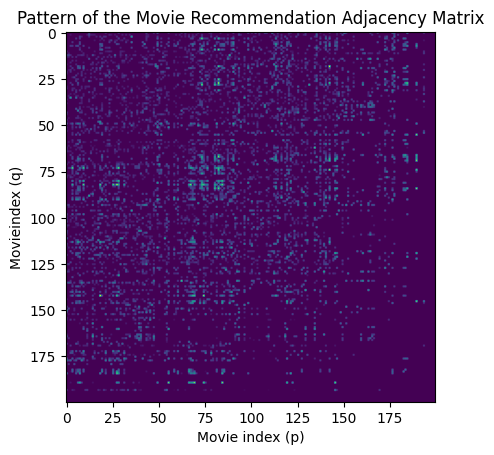

In [ ]:
plt.figure(1)
plt.title('Pattern of the Movie Recommendation Adjacency Matrix')
plt.xlabel('Movie index (p)')
plt.ylabel('Movieindex (q)')
plt.imshow(S.numpy())

In [ ]:
def movieMSELoss(yHat, y, idxMovie):
    """
    evaluates the square of comparing yHat(p) with y. The function
    accepts as an input tensors with multiple movie ratings.
    Inputs:
      yHat: torch.Tensor (NumUsers x 1 x NumMovies)
        A set of rating estimates. It includes estimates of all movies.
      y: torch.Tensor (NumUsers x 1)
        A specific rating of a specific movie
      idxMovie: torch.Tensor
        The index of the movie whose rating is given by y

    Outputs:
      mse: jnp.ndarray
        Computed mean squared error.

    """
    # the .squeeze() method is needed for dimension match between y and yHat
    yHat = yHat.squeeze()
    # Isolate the predictions in yHat that we will use for comparison
    prediction = yHat[:,idxMovie]
    return torch.mean((prediction-y)**2)

In [ ]:
def FilterFunction(x, h, S, b):
    '''
    The following function defines a Graph Filter.
    Inputs:
      x: Input to Graph Filter
      h: Filter
      S: Graph Shift Operator
      b: Bias term

      Outpus:
      y: Output of Graph Filter
    '''
    # X is  B x G x N
    # S is NxN
    B, G, N = x.shape
    K, _, F = h.shape
    y = torch.zeros((B, N, F), device=device)
    # The following for-loop is utilized to perform the graph diffusions
    for k in range(K):
        # sum S^k x * h_k
        # We permute x dimensions it to get dimensions B x N x G
        # The filter has dimensions G x F
        y += torch.matmul(x.permute((0,2,1)), h[k])
        # diffuse signal
        x = torch.matmul(x, S)
    # y has dims B x N x F,
    # add bias of shape F
    y = y + b.to(mps)
    # permute dimensions to get the desired dimensions B x F x N
    y = y.permute(0, 2, 1)
    return  y

In [ ]:
class FilterModule(nn.Module):
    #First we initialize the graph filter class and define the attributes
    def __init__(self, k, f_in, f_out):
        """
        initialize graph filter
        :param k: order of the filter
        :param f_in: filter input dimension
        :param f_out:  filter output dimension
        """
        super().__init__()
        self.k     = k
        self.f_in  = f_in
        self.f_out = f_out
        # initialize weights and bias
        self.bias = nn.parameter.Parameter(torch.Tensor(self.f_out))
        self.h = nn.Parameter(torch.randn(self.k, self.f_in, self.f_out))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.f_in * self.k)
        self.h.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, x, S):
        """
        PyTorch module interface implementation; just apply the filter
        """
        return FilterFunction(x, self.h, S, self.bias)

class GraphFilter(nn.Module):
  def __init__(self, k, f):
        """
        initialize graph filter
        :param k: order of the filters
        :param f: number of filters
        """
        super().__init__()
        self.k = k
        self.f = f
        # one input feature, f filter outputs
        self.filter_bank = FilterModule(self.k, 1, self.f)
        # add last linear layer, output dim=1
        self.readout = FilterModule(1, self.f, 1)
  def forward(self, x, S):
    x = self.filter_bank(x, S)
    return self.readout(x, S)

In [ ]:
k = 10
f = 64
model = GraphFilter(k, f)

In [ ]:
nEpochs = 10
learningRate = 0.01
batchSize = 20

optimizer = optim.Adam(model.parameters(), lr=learningRate)
batchIndex = np.append(np.arange(0, nTrain, batchSize), nTrain)
nBatches = int(np.ceil(nTrain/batchSize))

In [ ]:
lossTrain = []
lossTest = []
for epoch in range(nEpochs):
    randomPermutation = np.random.permutation(nTrain)
    idxEpoch = [int(i) for i in randomPermutation]
    epoch_loss=0
    for batch in tqdm(range(nBatches)):
        # Determine batch indices
        thisBatchIndices = idxEpoch[batchIndex[batch]
                                    : batchIndex[batch+1]]

        # Get the samples in this batch
        xTrainBatch = xTrain[thisBatchIndices,:,:]
        yTrainBatch = yTrain[thisBatchIndices]
        pTrainBatch = pTrain[thisBatchIndices]
        model.zero_grad()
        # Obtain the output of the architectures
        yHatTrainBatch = model(xTrainBatch, S)
        # Compute loss
        lossValueTrain = movieMSELoss(yHatTrainBatch, yTrainBatch, pTrainBatch)
        # Compute gradients
        lossValueTrain.backward()

        # Update parameters
        optimizer.step()

        #accumulate loss
        epoch_loss+=lossValueTrain.item()
        lossTrain.append(lossValueTrain.item())

        # Now compute the test loss
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # No need to track gradients
            # Assuming your test data is xTest, yTest, and pTest
            yHatTest = model(xTest, S)
            test_loss = movieMSELoss(yHatTest, yTest, pTest).item()  # Compute test loss
            lossTest.append(test_loss)  # Store test loss
    print(f"Epoch: {epoch+1} \t Loss: {epoch_loss/nBatches:.2f} \n")

100%|█████████████████████████████████████████| 138/138 [00:02<00:00, 50.19it/s]


Epoch: 1 	 Loss: 2.28 



100%|█████████████████████████████████████████| 138/138 [00:02<00:00, 51.71it/s]


Epoch: 2 	 Loss: 1.10 



100%|█████████████████████████████████████████| 138/138 [00:02<00:00, 51.84it/s]


Epoch: 3 	 Loss: 1.09 



100%|█████████████████████████████████████████| 138/138 [00:02<00:00, 51.47it/s]


Epoch: 4 	 Loss: 1.09 



100%|█████████████████████████████████████████| 138/138 [00:02<00:00, 51.42it/s]


Epoch: 5 	 Loss: 1.10 



100%|█████████████████████████████████████████| 138/138 [00:02<00:00, 50.48it/s]


Epoch: 6 	 Loss: 1.10 



100%|█████████████████████████████████████████| 138/138 [00:02<00:00, 52.03it/s]


Epoch: 7 	 Loss: 1.10 



100%|█████████████████████████████████████████| 138/138 [00:02<00:00, 55.31it/s]


Epoch: 8 	 Loss: 1.09 



100%|█████████████████████████████████████████| 138/138 [00:02<00:00, 55.15it/s]


Epoch: 9 	 Loss: 1.09 



100%|█████████████████████████████████████████| 138/138 [00:02<00:00, 49.67it/s]

Epoch: 10 	 Loss: 1.11 



In [ ]:
yHatTest = model(xTest, S)
testMSE = movieMSELoss(yHatTest, yTest, pTest)

print(f"Final Training Loss: {lossTrain[-1]:.2f}")
print(f"Final Test Loss: {lossTest[-1]:.2f}")

Final Training Loss: 0.63
Final Test Loss: 1.00


Text(0.5, 1.0, 'Graph Filter Training and Test Loss Evolution')

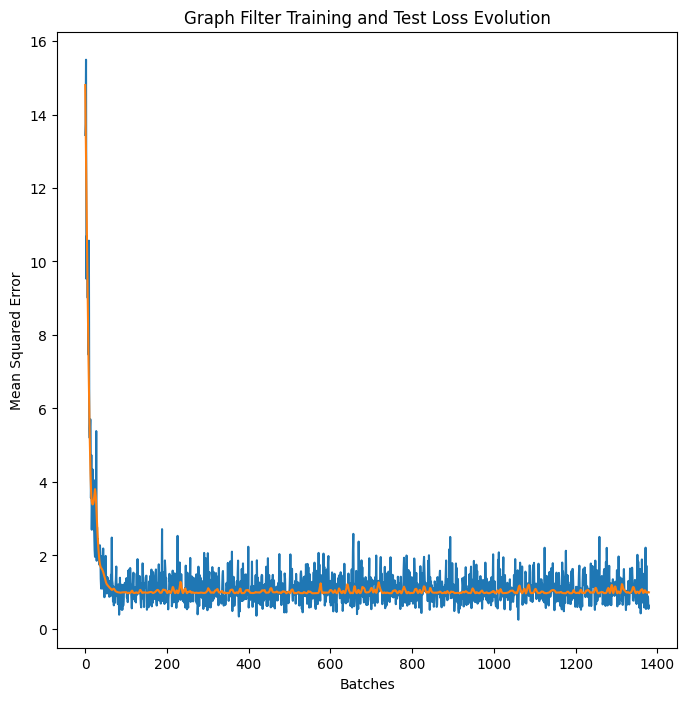

In [ ]:
plt.figure(figsize = (8,8))
plt.plot(lossTrain, label = 'Train MSE')
plt.plot(lossTest, label = 'Test MSE')
plt.ylabel('Mean Squared Error')
plt.xlabel('Batches')
plt.title('Graph Filter Training and Test Loss Evolution')